In [1]:
#pip install git+https://github.com/deepinv/deepinv.git#egg=deepinv
import deepinv as dinv
import torch
from torchvision.io import read_image
import numpy as np
import matplotlib.pyplot as plt
from deepinv.loss.metric import PSNR
perf_psnr = PSNR()

/projects/Rhapsodie/python397-deepinv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## 1- Download an image

In [3]:
image_path = "images/393035.jpg"
image_file = read_image(image_path)
x_true = image_file.unsqueeze(0).to(torch.float32).to(device)/255


## 2- Define the Forward Operator

Load a forward operator $A$ and generate some (noisy) measurements. See the [full list is of available operators](https://deepinv.github.io/deepinv/deepinv.physics.html).



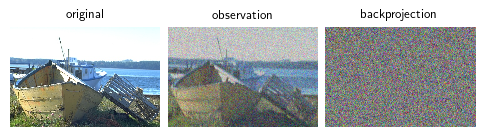

Power iteration converged at iteration 25, value=0.99


In [4]:

# Convolution forward model
filter_0 = dinv.physics.blur.gaussian_blur(sigma=(2, 0.9), angle=0.0)
physics = dinv.physics.Blur(filter_0, device=device, padding='reflect')

# Add noise in the forward model
physics.noise_model = dinv.physics.GaussianNoise(sigma=0.1)

y = physics(x_true)
back = physics.A_dagger(y)
dinv.utils.plot([x_true, y, back], titles=['original','observation','backprojection'])


tensor_shape = x_true.shape
random_tensor = torch.randn(tensor_shape).to(device)
Anorm2 = physics.compute_norm(random_tensor)



## 3- Reconstruction TV: Condat-Vu

In [4]:

# Define data fidelity term
data_fidelity = dinv.optim.L2()

# Define prior
L         =  dinv.optim.TVPrior().nabla
L_adjoint =  dinv.optim.TVPrior().nabla_adjoint
prior     =  dinv.optim.L12Prior()
Lnorm2    =  8   # this value comes from the DeepInv definition of finite difference operator

# Define regularization parameter
param_regul    = 0.03;

# Iterations
param_gamma    = 1                   # Set the step-size
param_iter     = 200                 # number of iterations
param_tau      = 0.9/(Anorm2/2 + Lnorm2*param_gamma)



xk = physics.A_adjoint(y)
vk = L(xk)
crit = 1e10*np.ones(param_iter)
psnr = 1e10*np.ones(param_iter)
for k in range(param_iter):

  x_prev = xk.clone()
  xk = xk - param_tau*data_fidelity.grad(xk, y, physics) - param_tau*L_adjoint(vk)
  tmp = vk+param_gamma*L(2*xk-x_prev)
  vk = tmp - param_gamma*prior.prox(tmp/param_gamma,gamma=param_regul/param_gamma)
  crit[k] = data_fidelity(xk, y, physics) + param_regul*prior.fn(L(xk))
  psnr[k] = perf_psnr(x_true,xk).item()
  if k % 10 == 0: print(f"crit[{k}]: {crit[k]}")


crit[0]: 2642.93701171875
crit[10]: 2551.794921875
crit[20]: 2523.22314453125
crit[30]: 2509.117919921875
crit[40]: 2500.739990234375
crit[50]: 2495.271240234375


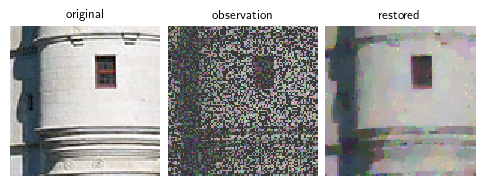

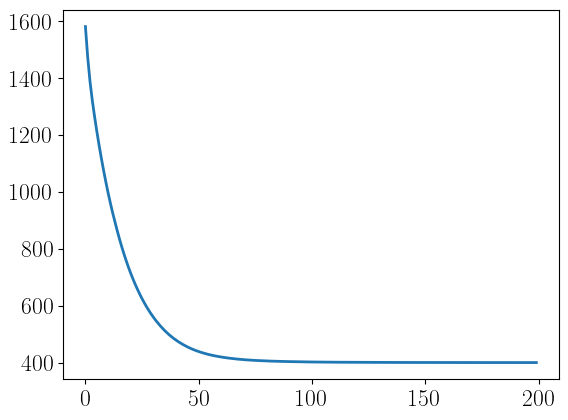

In [17]:
# Display results
dinv.utils.plot([x_true, y, xk], titles=['original','observation','restored'],figsize=[6,18])
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 2 lignes, 1 colonne
axs[0].plot(crit)
axs[0].legend()
axs[0].set_title('Objective function w.r.t iterations')
axs[1].plot(psnr)
axs[1].legend()
axs[1].set_title('PSNR function w.r.t iterations')
plt.tight_layout()
plt.show()
